In [1]:
using Muon
using Plots
using StatsPlots
using NearestNeighbors
using Distances

# Functions

In [2]:
function intrinsic_stability(adata; xkey = "X_ebd", vkey = "velocity_ebd", celltype = "clusters", n_neighbors = 30)
    celltype = adata.obs[!, celltype]
    labels = sort(unique(celltype))
    velocity_projection = adata.obsm[vkey]'
    embedding = adata.obsm[xkey]'

    celltype_cosine_similarity = Array{Array}(undef, 0)
    for label in labels
        temp_velocity_projection = velocity_projection[:, celltype .== label]
        temp_embedding = embedding[:, celltype .== label]

        kdTree = KDTree(temp_embedding)

        cell_cosine_similarity = Array{Float32}(undef, 0)
        for i in axes(temp_embedding, 2)
            idxs, _ = knn(kdTree, temp_embedding[:, i], n_neighbors + 1, true)
            idxs = idxs[2:end]
            cos_sim = []
            for j in axes(idxs, 1)
                if ~isnan(cosine_dist(temp_velocity_projection[:, i], temp_velocity_projection[:, idxs[j]]))
                    push!(cos_sim, 1 - cosine_dist(temp_velocity_projection[:, i], temp_velocity_projection[:, idxs[j]]))
                end
            end
            if ~isempty(cos_sim)
                cos_sim = sum(cos_sim) / length(cos_sim)
                push!(cell_cosine_similarity, cos_sim)
            end
        end

        push!(celltype_cosine_similarity, cell_cosine_similarity)
    end

    celltype_intrinsic_stability = Dict(k => v for (k, v) in zip(labels, celltype_cosine_similarity))

    return celltype_intrinsic_stability
end

intrinsic_stability (generic function with 1 method)

In [3]:
function extrinsic_stability(adata, differentiation_direction; xkey = "X_ebd", vkey = "velocity_ebd", celltype = "clusters", n_neighbors = 30)
    celltype_extrinsic_stability = Dict(item => Array{Float32}(undef, 0) for item in keys(differentiation_direction))
    
    celltype = adata.obs[!, celltype]
    labels = sort(unique(celltype))
    velocity_projection = adata.obsm[vkey]'
    embedding = adata.obsm[xkey]'

    kdTree = KDTree(embedding)

    for i in axes(embedding, 2)
        idxs, _ = knn(kdTree, embedding[:, i], n_neighbors + 1, true)
        idxs = idxs[2:end]

        if ~haskey(celltype_extrinsic_stability, celltype[i])
            continue
        end

        if typeof(differentiation_direction[celltype[i]]) == Vector{String}
            if length(findall(x -> x in differentiation_direction[celltype[i]], celltype[idxs])) == 0
                continue
            end
        elseif ~(differentiation_direction[celltype[i]] in celltype[idxs])
            continue
        end

        temp_cos_sim = []
        X̂ = embedding[:, idxs] .- embedding[:, i]

        for j in axes(X̂, 2)
            if typeof(differentiation_direction[celltype[i]]) == Vector{String}
                if celltype[idxs[j]] in differentiation_direction[celltype[i]]
                    push!(temp_cos_sim, 1 - cosine_dist(X̂[:, j], velocity_projection[:, i]))
                end
            else
                if celltype[idxs[j]] == differentiation_direction[celltype[i]]
                    push!(temp_cos_sim, 1 - cosine_dist(X̂[:, j], velocity_projection[:, i]))
                end
            end
        end

        temp_cos_sim = filter(isfinite, temp_cos_sim)
        if ~isempty(temp_cos_sim)
            temp_cos_sim = sum(temp_cos_sim) / length(temp_cos_sim)
            push!(celltype_extrinsic_stability[celltype[i]], temp_cos_sim)
        end
    end

    return celltype_extrinsic_stability
end

extrinsic_stability (generic function with 1 method)

In [4]:
function merge_for_boxplot(julovelo, scvelo, deepvelo, celldancer, labels)
    X = Array{Float32}(undef, 0)
    models = Array{Float32}(undef, 0)
    groups = Array{Float32}(undef, 0)

    for label in labels
        x = vcat(
            julovelo[label], 
            scvelo[label], 
            deepvelo[label], 
            celldancer[label]
        )
        model = vcat(
            ["JuloVelo" for i in 1:length(julovelo[label])],
            ["scVelo" for i in 1:length(scvelo[label])],
            ["DeepVelo" for i in 1:length(deepvelo[label])],
            ["cellDancer" for i in 1:length(celldancer[label])]
        )
        group = [label for i in 1:length(model)]

        X = vcat(X, x)
        models = vcat(models, model)
        groups = vcat(groups, group)
    end

    return X, models, groups
end

merge_for_boxplot (generic function with 1 method)

# Differentiation flow

In [5]:
differentiation_direction = Dict(
    "nIPC" => ["Radial Glia-like", "Neuroblast"],
    "Radial Glia-like" => "Astrocytes",
    "Neuroblast" => ["Granule immature", "Mossy"],
    "Mossy" => "Cck-Tox",
    "Granule immature" => "Granule mature",
    "Microglia" => "Endothelial",
    "OPC" => "OL"
)

Dict{String, Any} with 7 entries:
  "Microglia"        => "Endothelial"
  "OPC"              => "OL"
  "Granule immature" => "Granule mature"
  "nIPC"             => ["Radial Glia-like", "Neuroblast"]
  "Neuroblast"       => ["Granule immature", "Mossy"]
  "Radial Glia-like" => "Astrocytes"
  "Mossy"            => "Cck-Tox"

# Load data

In [6]:
theme(:vibrant, framestyle = :axes, grid = true, markersize = 3, linewidth = 1.4, palette = :tab20) 

In [7]:
julovelo_adata = readh5ad("data/JuloVelo.h5ad")
scvelo_adata = readh5ad("data/scvelo.h5ad")
deepvelo_adata = readh5ad("data/deepvelo.h5ad")
celldancer_adata = readh5ad("data/celldancer.h5ad")

AnnData object 2930 ✕ 1997

In [8]:
intrinsic_labels = sort(unique(julovelo_adata.obs.clusters))

14-element Vector{String}:
 "Astrocytes"
 "Cajal Retzius"
 "Cck-Tox"
 "Endothelial"
 "GABA"
 "Granule immature"
 "Granule mature"
 "Microglia"
 "Mossy"
 "Neuroblast"
 "OL"
 "OPC"
 "Radial Glia-like"
 "nIPC"

In [9]:
extrinsic_labels = [item for item in intrinsic_labels if item in keys(differentiation_direction)]

7-element Vector{String}:
 "Granule immature"
 "Microglia"
 "Mossy"
 "Neuroblast"
 "OPC"
 "Radial Glia-like"
 "nIPC"

In [10]:
intrinsic_palettes = Dict(
    "Astrocytes"=>"#3ba458",
    "Cajal Retzius"=>"#404040",
    "Cck-Tox"=>"#7a7a7a",
    "Endothelial"=>"#fda762",
    "GABA"=>"#6950a3",
    "Granule immature"=>"#2575b7",
    "Granule mature"=>"#08306b",
    "Microglia"=>"#e1bfb0",
    "Mossy"=>"#e5d8bd",
    "Neuroblast"=>"#79b5d9",
    "OL"=>"#f14432",
    "OPC"=>"#fc8a6a",
    "Radial Glia-like"=>"#98d594",
    "nIPC"=>"#d0e1f2"
)

Dict{String, String} with 14 entries:
  "Astrocytes"       => "#3ba458"
  "Granule immature" => "#2575b7"
  "OL"               => "#f14432"
  "GABA"             => "#6950a3"
  "Endothelial"      => "#fda762"
  "Mossy"            => "#e5d8bd"
  "Cajal Retzius"    => "#404040"
  "Microglia"        => "#e1bfb0"
  "Cck-Tox"          => "#7a7a7a"
  "Granule mature"   => "#08306b"
  "nIPC"             => "#d0e1f2"
  "Neuroblast"       => "#79b5d9"
  "Radial Glia-like" => "#98d594"
  "OPC"              => "#fc8a6a"

In [11]:
extrinsic_palettes = Dict(
    "Granule immature"=>"#2575b7",
    "Microglia"=>"#e1bfb0",
    "Mossy"=>"#e5d8bd",
    "Neuroblast"=>"#79b5d9",
    "OPC"=>"#fc8a6a",
    "Radial Glia-like"=>"#98d594",
    "nIPC"=>"#d0e1f2"
)

Dict{String, String} with 7 entries:
  "OPC"              => "#fc8a6a"
  "Radial Glia-like" => "#98d594"
  "Granule immature" => "#2575b7"
  "nIPC"             => "#d0e1f2"
  "Neuroblast"       => "#79b5d9"
  "Mossy"            => "#e5d8bd"
  "Microglia"        => "#e1bfb0"

In [12]:
intrinsic_colors = [intrinsic_palettes[label] for label in intrinsic_labels]
intrinsic_colors = reshape([parse(Colorant, item) for item in intrinsic_colors], 1, :)

In [13]:
extrinsic_colors = [extrinsic_palettes[label] for label in extrinsic_labels if ~(label in ["OPC", "Microglia"])]
extrinsic_colors = reshape([parse(Colorant, item) for item in extrinsic_colors], 1, :)

# Intrinsic stability

In [14]:
julovelo_intrinsic_stability = intrinsic_stability(julovelo_adata; xkey = "X_umap", vkey = "velocity_umap", n_neighbors = 10)
scvelo_intrinsic_stability = intrinsic_stability(scvelo_adata; xkey = "X_umap", vkey = "velocity_umap", n_neighbors = 10)
deepvelo_intrinsic_stability = intrinsic_stability(deepvelo_adata; xkey = "X_umap", vkey = "velocity_umap", n_neighbors = 10)
celldancer_intrinsic_stability = intrinsic_stability(celldancer_adata; xkey = "X_cdr", vkey = "velocity_cdr", n_neighbors = 10)

Dict{String, Vector{Float32}} with 14 entries:
  "Astrocytes"       => [0.995009, 0.967517, 0.990726, 0.99233, 0.889898, 0.978…
  "Granule immature" => [0.264616, 0.207713, -0.187847, 0.999562, 0.988152, 0.8…
  "GABA"             => [0.421167, 0.919152, -0.10296, 0.919308, 0.438768, -0.1…
  "Microglia"        => [0.757333, 0.641801, -0.713625, 0.324461, 0.744982, 0.6…
  "Cck-Tox"          => [0.980536, 0.991225, 0.877766, 0.952817, 0.98003, 0.800…
  "Neuroblast"       => [0.977022, 0.961581, 0.991094, 0.996158, 0.920407, 0.38…
  "Radial Glia-like" => [0.922949, 0.944698, 0.355314, 0.861991, 0.482865, 0.90…
  "OL"               => [0.209918, 0.853606, 0.981898, 0.485071, -0.587826, -0.…
  "Endothelial"      => [0.501439, 0.424229, 0.50576, 0.570489, 0.718851, 0.310…
  "Mossy"            => [0.95841, 0.978753, 0.999974, 0.997524, 0.978753, 0.468…
  "Cajal Retzius"    => [0.46792, 0.834664, 0.0210926, 0.593488, 0.857014, 0.74…
  "Granule mature"   => [0.790339, 0.514068, 0.902635, 0.92376

In [15]:
in_X, in_models, in_groups = merge_for_boxplot(julovelo_intrinsic_stability, scvelo_intrinsic_stability, deepvelo_intrinsic_stability, celldancer_intrinsic_stability, intrinsic_labels)

(Float32[0.8688547, 0.3057297, 0.25805584, 0.4580785, 0.38133714, 0.50528914, 0.54348946, 0.38655892, 0.3927966, 0.8072604  …  0.97401696, 0.9648947, 0.996132, 0.97058606, 0.9878885, 0.9907837, 0.99104035, 0.98610616, 0.97613406, 0.98636866], Any["JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo"  …  "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo"], Any["Astrocytes", "Astrocytes", "Astrocytes", "Astrocytes", "Astrocytes", "Astrocytes", "Astrocytes", "Astrocytes", "Astrocytes", "Astrocytes"  …  "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC"])

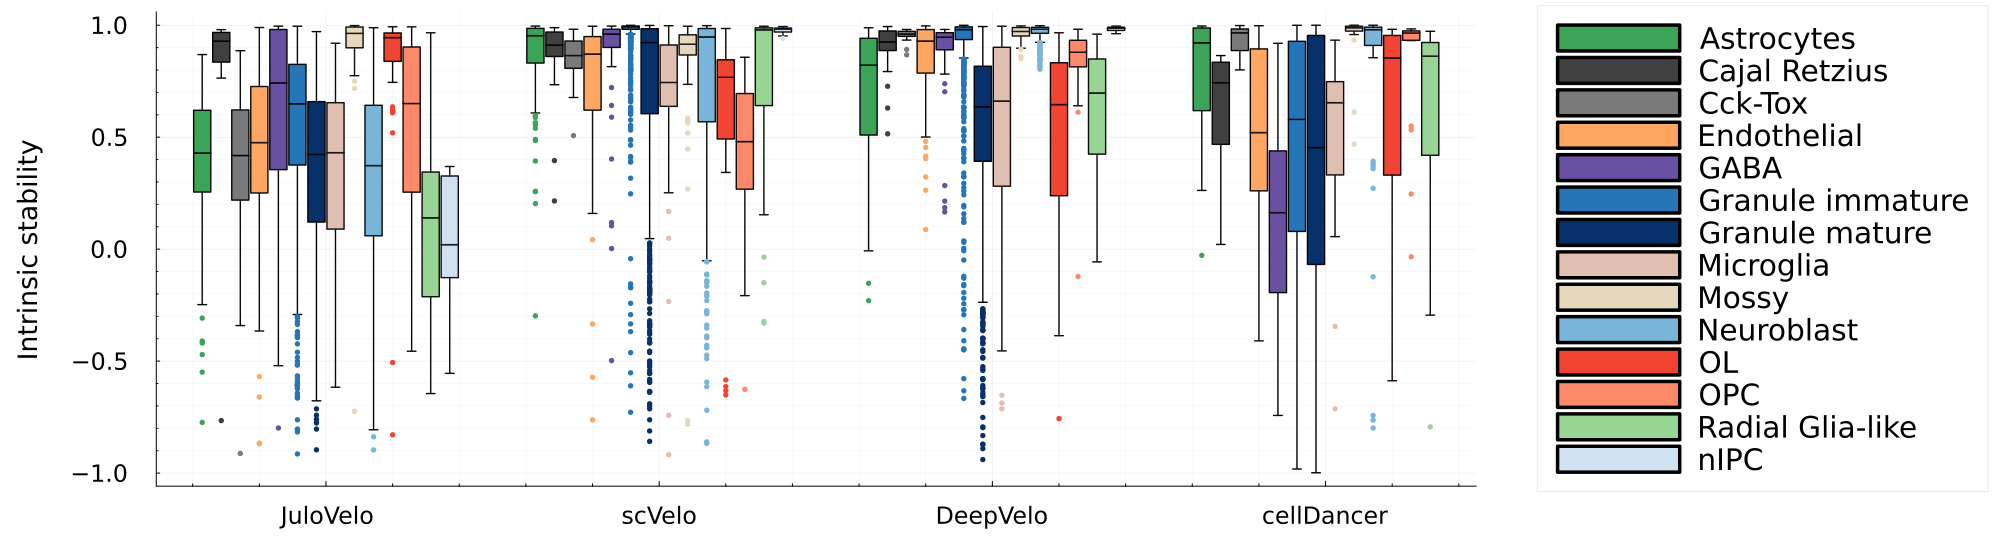

In [16]:
p = groupedboxplot(in_models, in_X, group = in_groups, size = (2000, 550), color = intrinsic_colors, legend = :outerright,
    tickfontsize = 16, guidefontsize = 18, left_margin = 1.5Plots.cm, bottom_margin = 1.0Plots.cm, legendfontsize = 20, ylabel = "Intrinsic stability"
)

In [17]:
savefig(p, "figure/dentategyrus_intrinsic_stability.png")

"/media/data/bmi111/KuanChiun/JuloVelo/thesis/results/dentategyrus/full/figure/dentategyrus_intrinsic_stability.png"

# Extrinsic stability

In [18]:
julovelo_extrinsic_stability = extrinsic_stability(julovelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap", n_neighbors = 10)
scvelo_extrinsic_stability = extrinsic_stability(scvelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap", n_neighbors = 10)
deepvelo_extrinsic_stability = extrinsic_stability(deepvelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap", n_neighbors = 10)
celldancer_extrinsic_stability = extrinsic_stability(celldancer_adata, differentiation_direction; xkey = "X_cdr", vkey = "velocity_cdr", n_neighbors = 10)

Dict{String, Vector{Float32}} with 7 entries:
  "OPC"              => []
  "Mossy"            => []
  "Granule immature" => [-0.0737851, 0.841249, -0.857096, -0.298191, -0.0950093…
  "nIPC"             => []
  "Neuroblast"       => [-0.344822, 0.349188, 0.99084, -0.228856, 0.884486, -0.…
  "Radial Glia-like" => [0.996522, 0.753117]
  "Microglia"        => []

In [19]:
ex_X, ex_models, ex_groups = merge_for_boxplot(julovelo_extrinsic_stability, scvelo_extrinsic_stability, deepvelo_extrinsic_stability, celldancer_extrinsic_stability, extrinsic_labels)

(Float32[0.19343136, -0.21959841, 0.9955671, -0.02920178, -0.04348434, -0.75645864, -0.31551582, -0.6056808, 0.6519184, 0.7956906  …  0.993758, -0.9518511, -0.9975141, 0.9999065, 0.8106928, 0.9516263, 0.19634672, 0.9861828, -0.9432795, 0.99916786], Any["JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo", "JuloVelo"  …  "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo", "DeepVelo"], Any["Granule immature", "Granule immature", "Granule immature", "Granule immature", "Granule immature", "Granule immature", "Granule immature", "Granule immature", "Granule immature", "Granule immature"  …  "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC", "nIPC"])

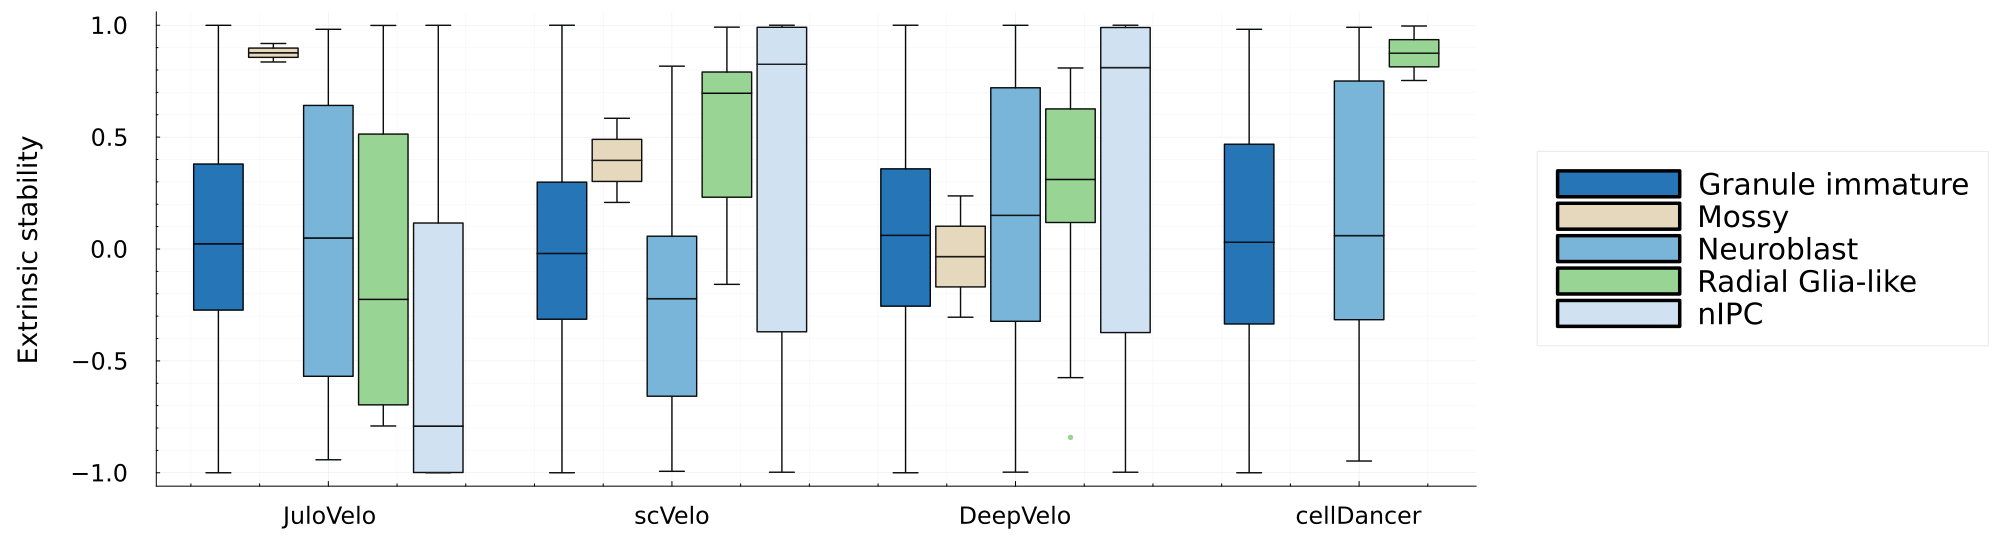

In [20]:
p = groupedboxplot(ex_models, ex_X, group = ex_groups, size = (2000, 550), color = extrinsic_colors, legend = :outerright,
    tickfontsize = 16, guidefontsize = 18, left_margin = 1.5Plots.cm, bottom_margin = 1.0Plots.cm, legendfontsize = 20, ylabel = "Extrinsic stability"
)

In [21]:
savefig(p, "figure/dentategyrus_extrinsic_stability.png")

"/media/data/bmi111/KuanChiun/JuloVelo/thesis/results/dentategyrus/full/figure/dentategyrus_extrinsic_stability.png"